### 读取数据，数据清洗

In [98]:
import pandas as pd

# 读取Excel文件
df = pd.read_excel(
    'data/Served Meal Count.xlsx',
    usecols=['Date','Breakfast Order','Breakfast Served','Lunch Order', 'Lunch Served']
)

# 将Date列转换为pandas库特有的datetime格式
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Breakfast Order,Breakfast Served,Lunch Order,Lunch Served
0,2023-08-21,380.0,289.0,350.0,275.0
1,2023-08-22,380.0,332.0,350.0,272.0
2,2023-08-23,380.0,346.0,350.0,288.0
3,2023-08-24,380.0,366.0,350.0,292.0
4,2023-08-25,380.0,367.0,312.0,284.0
...,...,...,...,...,...
299,2024-10-03,380.0,384.0,390.0,324.0
300,2024-10-04,380.0,381.0,390.0,300.0
301,2024-10-05,NaN,NaN,NaN,NaN
302,2024-10-06,NaN,NaN,NaN,NaN


In [99]:
# 生成完整的日期范围，后续将使用
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
# 索引设置为Date列
df.set_index('Date', inplace=True)
df

,Breakfast Order,Breakfast Served,Lunch Order,Lunch Served
Date,,,,
2023-08-21,380.0,289.0,350.0,275.0
2023-08-22,380.0,332.0,350.0,272.0
2023-08-23,380.0,346.0,350.0,288.0
2023-08-24,380.0,366.0,350.0,292.0
2023-08-25,380.0,367.0,312.0,284.0
...,...,...,...,...
2024-10-03,380.0,384.0,390.0,324.0
2024-10-04,380.0,381.0,390.0,300.0
2024-10-05,NaN,NaN,NaN,NaN


In [100]:
# 重索引到完整的日期范围，缺失的日期行填充为NaN
df = df.reindex(date_range)
df

,Breakfast Order,Breakfast Served,Lunch Order,Lunch Served
2023-08-21,380.0,289.0,350.0,275.0
2023-08-22,380.0,332.0,350.0,272.0
2023-08-23,380.0,346.0,350.0,288.0
2023-08-24,380.0,366.0,350.0,292.0
2023-08-25,380.0,367.0,312.0,284.0
...,...,...,...,...
2024-10-03,380.0,384.0,390.0,324.0
2024-10-04,380.0,381.0,390.0,300.0
2024-10-05,NaN,NaN,NaN,NaN
2024-10-06,NaN,NaN,NaN,NaN


In [101]:
# 对于缺失值，填充为0
df.fillna(0, inplace=True)
df

,Breakfast Order,Breakfast Served,Lunch Order,Lunch Served
2023-08-21,380.0,289.0,350.0,275.0
2023-08-22,380.0,332.0,350.0,272.0
2023-08-23,380.0,346.0,350.0,288.0
2023-08-24,380.0,366.0,350.0,292.0
2023-08-25,380.0,367.0,312.0,284.0
...,...,...,...,...
2024-10-03,380.0,384.0,390.0,324.0
2024-10-04,380.0,381.0,390.0,300.0
2024-10-05,0.0,0.0,0.0,0.0
2024-10-06,0.0,0.0,0.0,0.0


### 原始数据可视化

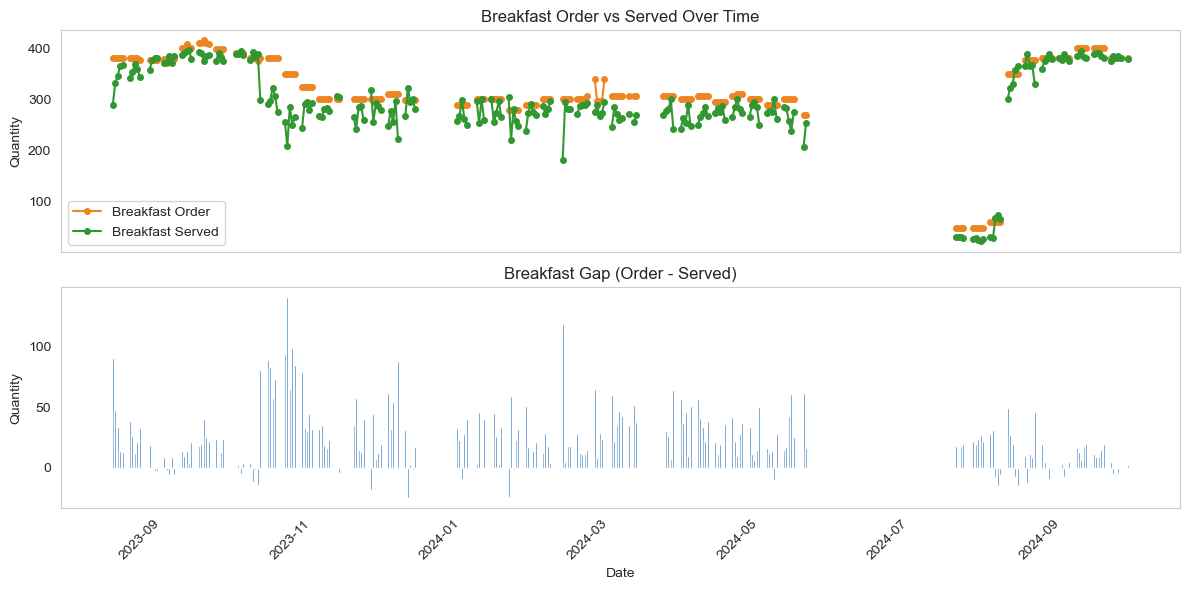

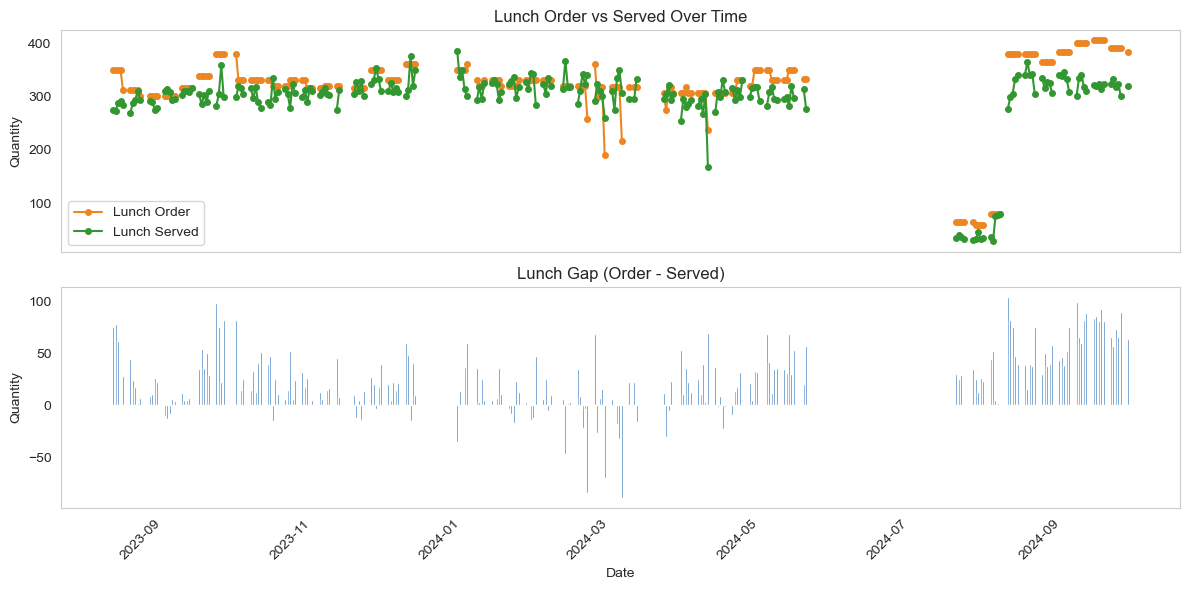

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 df 已定义并包含 'Lunch Order' 和 'Lunch Served' 列
# 创建绘图需要的数据，将其中的 0 替换为 NaN, 这样画出的图好看些
breakfast_served_plot = df['Breakfast Served'].replace(0, np.nan)
breakfast_order_plot = df['Breakfast Order'].replace(0, np.nan)
lunch_served_plot = df['Lunch Served'].replace(0, np.nan)
lunch_order_plot = df['Lunch Order'].replace(0, np.nan)

# 计算差值
breakfast_order_served_diff = breakfast_order_plot - breakfast_served_plot
lunch_order_served_diff = lunch_order_plot - lunch_served_plot

# 创建第一个画布，包含早餐的子图
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# 第一个子图：早餐折线图
ax1.plot(breakfast_order_plot, label='Breakfast Order', color=np.array([237, 134, 34]) / 255, alpha=1, marker='o', markersize=4)  # 橙色
ax1.plot(breakfast_served_plot, label='Breakfast Served', color=np.array([50, 151, 49]) / 255, marker='o', markersize=4)  # 绿色
ax1.set_title('Breakfast Order vs Served Over Time')
ax1.set_ylabel('Quantity')
ax1.legend()
ax1.grid()

# 第二个子图：早餐差值的柱状图
ax2.bar(breakfast_served_plot.index, breakfast_order_served_diff, color=np.array([51, 120, 188]) / 255)
ax2.set_title('Breakfast Gap (Order - Served)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Quantity')
ax2.grid()

# 调整 x 轴标签旋转以便更好地显示
plt.xticks(rotation=45)
plt.tight_layout()  # 自动调整子图布局以适应整个画布
plt.show()

# 创建第二个画布，包含午餐的子图
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# 第一个子图：午餐折线图
ax3.plot(lunch_order_plot, label='Lunch Order', color=np.array([237, 134, 34]) / 255, alpha=1, marker='o', markersize=4)  # 橙色
ax3.plot(lunch_served_plot, label='Lunch Served', color=np.array([50, 151, 49]) / 255, marker='o', markersize=4)  # 绿色
ax3.set_title('Lunch Order vs Served Over Time')
ax3.set_ylabel('Quantity')
ax3.legend()
ax3.grid()

# 第二个子图：午餐差值的柱状图
ax4.bar(lunch_served_plot.index, lunch_order_served_diff, color=np.array([51, 120, 188]) / 255)
ax4.set_title('Lunch Gap (Order - Served)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Quantity')
ax4.grid()

# 调整 x 轴标签旋转以便更好地显示
plt.xticks(rotation=45)
plt.tight_layout()  # 自动调整子图布局以适应整个画布
plt.show()


### 特征提取
1. 以Breakfast为例，当天的served可能（注意是“可能”，因为特征提取是一个经验+猜测的过程）与“月份”、“星期”、“节假日（法定节假日、寒春暑假）”、“当天是一年中的第几天”、“前7日Breakfast的served量”、“前7日Lunch的served量”等有关。因此我们使用这些量来预测当日的served。
2. 你可能会问：只使用前几天的served量（例如“前7日Breakfast的served量”）来预测当日的served量不行吗，为啥还要考虑“月份”、“星期”、“节假日”？ “星期”、“节假日”还是很好理解的，在周六日、节假日放假时，不论前几天的served量为多少，当日的served都为0，如果不考虑“星期”、“节假日”，那么会出现当日的served预测量不为0，这就不合理了。因此只有在不是周六日、节假日时，预测才是有意义合理的。对于“月份”，我们的猜测是这样的：均不是周六日、节假日的两天，他们前几天的served量、served量的变化趋势可能是一致的，但是由于季节月份的不同，他们两在当日的预测“公式”可能不一样（例如，在冬季太冷了，学生们可能更愿意在家吃完早饭再去学校，毕竟要冻死孩子了~当然这也这是猜测，实际跟“月份”有没有关系，我们后面还需进行验证。）
3. 下面计算了1中提到的各种量

#### 提取可能有用的特征

In [103]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.pyplot as plt

# 使用holidays库生成美国法定假期标记：简单点来说，这个库知道每一年的法定节假日，而且可以自己自定义设定节假日（例如寒暑假）
us_holidays = holidays.US()
# 自定义寒暑假时间段：这个是根据数据表中订单量请情况推断出来的
winter_break = pd.date_range(start='2023-12-25', end='2024-01-05')
spring_break = pd.date_range(start='2024-03-22', end='2024-03-25')
summer_break = pd.date_range(start='2024-06-03', end='2024-08-20')
# 将寒暑假添加到holidays中，作为自定义的假期标记
for date in winter_break:
    us_holidays[date] = "Winter Break"
for date in spring_break:
    us_holidays[date] = "Spring Break"
for date in summer_break:
    us_holidays[date] = "Summer Break"
# 将上面的“节假日”信息添加进原始的df数据表中
df['Is_Holiday'] = df.index.map(lambda x: 1 if x in us_holidays else 0)

# 将“星期”信息添加进df数据表
df['Day_of_Week'] = df.index.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)

# 将“月份”、“当天是一年中的第几天”添加进df数据表
df['Month'] = df.index.month                   # 所属月份
df['Day_of_Year'] = df.index.dayofyear          # 当年中的第几天

# 将滞后特征（“前7日Breakfast的served量”、“前7日Lunch的served量”）添加进df数据表
# 当日的served量与前几天的served量是有一定关系的，这点应该挺容易理解的吧
for i in range(1, 8):  # 过去7天的订餐量
    df[f'Breakfast_Lag_{i}'] = df['Breakfast Served'].shift(i)
    df[f'Lunch_Lag_{i}'] = df['Lunch Served'].shift(i)

# 对于可能出现的缺失值，将其填充为0
df.fillna(0, inplace=True)
# 查看以下现在的df数据表是什么样
df
# 可以看到，现在的df中，不仅有Breakfast Order、Breakfast Served、Lunch Order、Lunch Served，还有刚刚计算后加进去的各种新的特征。
# Is_Holiday: "0"表示不是节假日（法定、寒春暑假），"1"表示是节假日。
# Day_of_Week: 0~6依次表示周一~周日
# Is_Weekend： "0"表示不是周末，"1"表示是周末
# Month: 月份
# Day_of_Year: 当年中的第几天
# Breakfast_Lag_1 ~ Breakfast_Lag_7: 前7日Breakfast的served量
# Lunch_Lag_1 ~ Lunch_Lag_7: 前7日Lunch的served量
# df数据表中既有我们的目标变量（Breakfast Served、Lunch Served），也有我们将用于预测的因变量（”节假日“、”Breakfast_Lag_7“等总计19个），更专业点讲，这19个因变量叫做”特征“。

,Breakfast Order,Breakfast Served,Lunch Order,Lunch Served,Is_Holiday,Day_of_Week,Is_Weekend,Month,Day_of_Year,Breakfast_Lag_1,...,Breakfast_Lag_3,Lunch_Lag_3,Breakfast_Lag_4,Lunch_Lag_4,Breakfast_Lag_5,Lunch_Lag_5,Breakfast_Lag_6,Lunch_Lag_6,Breakfast_Lag_7,Lunch_Lag_7
2023-08-21,380.0,289.0,350.0,275.0,0,0,0,8,233,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-22,380.0,332.0,350.0,272.0,0,1,0,8,234,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-23,380.0,346.0,350.0,288.0,0,2,0,8,235,332.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-24,380.0,366.0,350.0,292.0,0,3,0,8,236,346.0,...,289.0,275.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-25,380.0,367.0,312.0,284.0,0,4,0,8,237,366.0,...,332.0,272.0,289.0,275.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03,380.0,384.0,390.0,324.0,0,3,0,10,277,380.0,...,375.0,324.0,0.0,0.0,0.0,0.0,380.0,324.0,385.0,313.0
2024-10-04,380.0,381.0,390.0,300.0,0,4,0,10,278,384.0,...,385.0,333.0,375.0,324.0,0.0,0.0,0.0,0.0,380.0,324.0
2024-10-05,0.0,0.0,0.0,0.0,0,5,1,10,279,381.0,...,380.0,317.0,385.0,333.0,375.0,324.0,0.0,0.0,0.0,0.0
2024-10-06,0.0,0.0,0.0,0.0,0,6,1,10,280,0.0,...,384.0,324.0,380.0,317.0,385.0,333.0,375.0,324.0,0.0,0.0


#### 筛选真正有用的特征
1. 上面所讲的19个特征只是我们初步认为在预测中可能有用的信息，我们还需验证他们是否真正有用。我们可以使用皮尔森相关系数（pearson）计算目标变量（'Breakfast Served'、'Lunch Served'）与19个特征之间的相关性，某个特征与目标变量相关性的绝对值越接近于1，说明该特征与目标变量越有关，该特征是相对有效的，可以用来进行预测。

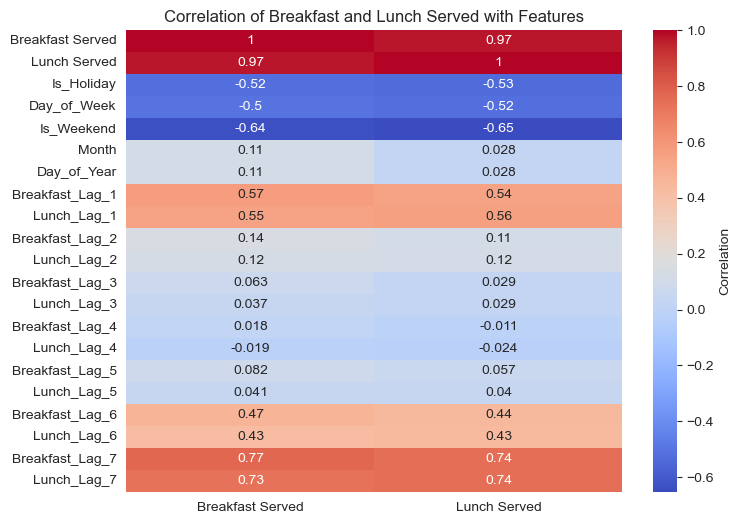

In [104]:
# 计算相关矩阵
# 这里计算的是目标变量（'Breakfast Served'、'Lunch Served'）、暂时用不上的量（'Breakfast Order'、'Lunch Order'）、19个特征，总计23个变量两两之间的相关性。
# 但是其中有一些相关性是用不上或者无意义的，例如‘Breakfast Served’和‘Breakfast Served’自己的相关性为1，这就没有任何意义。
# 因此我们需要从计算出的相关性矩阵中提取出对我们有意义的部分相关性
correlation_matrix = df.corr()

# 提取 'Breakfast Served' 和 'Lunch Served' 与19个特征之间的相关性
target_corr = correlation_matrix[['Breakfast Served', 'Lunch Served']].drop(['Breakfast Order', 'Lunch Order'])

# 绘制相关性矩阵的热力图
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title("Correlation of Breakfast and Lunch Served with Features")
plt.show()
# 从热力图中我们可以发现，'Breakfast Served'与'Is_Holiday'、'Day_of_Week'、'Is_Weekend'、'Breakfast_Lag_1'、'Lunch_Lag_1'、'Breakfast_Lag_7'、'Lunch_Lag_7'的相关性较大（大于等于0.5）
# 'Lunch Served'的情况也类似
# 因此我们打算选用'Is_Holiday'、'Day_of_Week'、'Is_Weekend'、'Breakfast_Lag_1'、'Lunch_Lag_1'、'Breakfast_Lag_7'、'Lunch_Lag_7'共7个特征作为有用的特征来使用

In [105]:
# 筛选出与目标变量相关性绝对值大于等于0.5的特征列
selected_features = target_corr[(target_corr.abs() >= 0.5).any(axis=1)]
selected_feature_names = selected_features.index.tolist()
selected_features
# 'Breakfast Served'和'Lunch Served'各自的相关特征恰巧是一样的，因此两者可以使用相同的特征数据进行预测

,Breakfast Served,Lunch Served
Breakfast Served,1.000000,0.968119
Lunch Served,0.968119,1.000000
Is_Holiday,-0.521860,-0.534278
Day_of_Week,-0.504454,-0.521132
Is_Weekend,-0.638133,-0.654544
Breakfast_Lag_1,0.570908,0.542492
Lunch_Lag_1,0.546059,0.556128
Breakfast_Lag_7,0.768948,0.742066
Lunch_Lag_7,0.728579,0.742151


In [106]:
# 根据上面筛选出来的有效特征名，从df数据表中提取出这些有效特征
filtered_features = df[selected_feature_names]
filtered_features
# 至此，我们已经完成了从原始数据中进行特征提取的工作。提取出来的特征将作为我们的因变量用来预测目标变量（'Breakfast Served', 'Lunch Served'）

,Breakfast Served,Lunch Served,Is_Holiday,Day_of_Week,Is_Weekend,Breakfast_Lag_1,Lunch_Lag_1,Breakfast_Lag_7,Lunch_Lag_7
2023-08-21,289.0,275.0,0,0,0,0.0,0.0,0.0,0.0
2023-08-22,332.0,272.0,0,1,0,289.0,275.0,0.0,0.0
2023-08-23,346.0,288.0,0,2,0,332.0,272.0,0.0,0.0
2023-08-24,366.0,292.0,0,3,0,346.0,288.0,0.0,0.0
2023-08-25,367.0,284.0,0,4,0,366.0,292.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-10-03,384.0,324.0,0,3,0,380.0,317.0,385.0,313.0
2024-10-04,381.0,300.0,0,4,0,384.0,324.0,380.0,324.0
2024-10-05,0.0,0.0,0,5,1,381.0,300.0,0.0,0.0
2024-10-06,0.0,0.0,0,6,1,0.0,0.0,0.0,0.0


### 数据集划分
1. 在进行机器学习任务时，一般都会将全部数据集分割成训练集和验证集，训练集用于训练模型，验证集用于验证模型在未知数据集上的表现效果
2. 我们的数据集从2023/08/21至2024/10/07，我们将2023/08/21至2024/08/19作为训练集，将剩余的2024/08/19至2024/10/07作为验证集

In [107]:
# 上面的filtered_features是我们筛选出的有效特征，我们将其赋值copy给X
# 从df数据表中提取两个目标变量'Breakfast Served'、'Lunch Served'，并赋值copy
X = filtered_features
y_breakfast = df['Breakfast Served']
y_lunch = df['Lunch Served']
# 这两个order在模型训练时用不到，但是在后面可视化过程中用得到，这里是提前计算好备用。
order_breakfast = df['Breakfast Order']
order_lunch = df['Lunch Order']

# 设置划分时间点
cutoff_date = '2024-08-19'
# 根据划分时间点获取训练数据的时间索引、测试数据的时间索引
train_mask = X.index < cutoff_date
test_mask = X.index >= cutoff_date

In [108]:
# 训练集
# 根据训练数据的时间索引提取相关数据
# 由前面的相关性分析可知，'Breakfast Served'和'Lunch Served'的有效特征变量恰巧是一致的7个特征，因此X_train_breakfast = X_train_lunch
X_train_breakfast = X_train_lunch = X[train_mask]
y_train_breakfast = y_breakfast[train_mask]
y_train_lunch = y_lunch[train_mask]
# 将训练数据（目标变量Breakfast Served（在现阶段也称为标签，因为它是历史真实的served，是模型可以参考的标准答案）、7个特征（现阶段也称为模型输入，就是模型要学习的东西））随机打乱
# 未打乱前，训练数据是按照时间顺序分布排列的，在机器学历领域，这种情况是不利于模型训练的。我们需要将时间先后顺序打乱，例如原先是1，2，3，4，5，...排列的，现在随机打乱成100，64，2，48，414，...。且模型输入和相对应的标签是同步打乱的。
X_train_breakfast_shuffled, y_train_breakfast_shuffled = shuffle(X_train_breakfast, y_train_breakfast, random_state=42)
X_train_lunch_shuffled, y_train_lunch_shuffled = shuffle(X_train_lunch, y_train_lunch, random_state=42)
# order
order_train_breakfast = order_breakfast[train_mask]
order_train_lunch = order_lunch[train_mask]

# 同理获得测试集，不过验证集不需要打乱，因为验证集不会被模型学习，所以怎么样都不会影响模型训练
# 根据测试数据的时间索引提取相关数据
X_test_breakfast = X_test_lunch = X[test_mask]
y_test_breakfast = y_breakfast[test_mask]
y_test_lunch = y_lunch[test_mask]
# order
order_test_breakfast = order_breakfast[test_mask]
order_test_lunch = order_lunch[test_mask]

In [109]:
# ***** 以下单元（含本单元）的代码主要是为了方便观察数据，不涉及实质性的功能，可以在理解后可以自己决定是否删除 *****

In [110]:
# 查看训练数据打乱前后的时间顺序对比
X_train_breakfast

,Breakfast Served,Lunch Served,Is_Holiday,Day_of_Week,Is_Weekend,Breakfast_Lag_1,Lunch_Lag_1,Breakfast_Lag_7,Lunch_Lag_7
2023-08-21,289.0,275.0,0,0,0,0.0,0.0,0.0,0.0
2023-08-22,332.0,272.0,0,1,0,289.0,275.0,0.0,0.0
2023-08-23,346.0,288.0,0,2,0,332.0,272.0,0.0,0.0
2023-08-24,366.0,292.0,0,3,0,346.0,288.0,0.0,0.0
2023-08-25,367.0,284.0,0,4,0,366.0,292.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-08-14,68.0,75.0,1,2,0,29.0,28.0,26.0,45.0
2024-08-15,75.0,78.0,1,3,0,68.0,75.0,23.0,32.0
2024-08-16,66.0,80.0,1,4,0,75.0,78.0,28.0,35.0
2024-08-17,0.0,0.0,1,5,1,66.0,80.0,0.0,0.0


In [111]:
X_train_breakfast_shuffled

,Breakfast Served,Lunch Served,Is_Holiday,Day_of_Week,Is_Weekend,Breakfast_Lag_1,Lunch_Lag_1,Breakfast_Lag_7,Lunch_Lag_7
2024-03-01,292.0,341.0,0,4,0,289.0,324.0,282.0,317.0
2023-09-23,0.0,0.0,0,5,1,379.0,315.0,0.0,0.0
2023-09-05,358.0,291.0,0,1,0,0.0,0.0,354.0,288.0
2024-08-02,0.0,0.0,1,4,0,30.0,32.0,0.0,0.0
2023-10-17,392.0,297.0,0,1,0,376.0,315.0,389.0,298.0
...,...,...,...,...,...,...,...,...,...
2023-10-31,209.0,305.0,0,1,0,256.0,314.0,297.0,283.0
2023-12-05,256.0,330.0,0,1,0,318.0,323.0,242.0,327.0
2024-05-17,262.0,294.0,0,4,0,300.0,295.0,250.0,291.0
2024-08-03,0.0,0.0,1,5,1,0.0,0.0,0.0,0.0


In [112]:
# ***** 以上单元（含本单元）的代码主要是为了方便观察数据，不涉及实质性的功能，可以在理解后可以自己决定是否删除 *****

### 模型训练与验证

#### 训练推理

In [113]:
# 初始化模型，这里选择了随机森林模型。暂且可以先不用管随机森林的具体内容。
# 使用随机森林回归模型
# 这里选择为'Breakfast Served'和'Lunch Served'分别构建一个模型，效果还可以。也尝试了使用一个模型一次性完成两个量的预测，感觉效果一般，暂时就不弄了。
breakfast_model = RandomForestRegressor(n_estimators=256, random_state=42)
lunch_model = RandomForestRegressor(n_estimators=256, random_state=42)

In [114]:
# 训练模型
# 将准备好的输入特征和标签给到模型，模型将学习输入特征和标签之间的隐藏映射关系f。当学习到了这个f后，我们给模型一个新的输入特征（未来的某个时间）后，模型就可以使用这个f来预测未来的served。
# 这里不要忘了，由于Breakfast Served和Lunch Served的影响因素恰巧相同，所以这里的X_train_breakfast_shuffled=X_train_lunch_shuffled，这里使用两个变量主要是为了更好的区分这是两个模型，避免混淆。
breakfast_model.fit(X_train_breakfast_shuffled, y_train_breakfast_shuffled)
lunch_model.fit(X_train_lunch_shuffled, y_train_lunch_shuffled)
# 模型的训练过程是比较抽象的，通常我们不太需要关注这个训练过程，所以整个训练过程就一个fit方法就搞定了。

RandomForestRegressor(n_estimators=256, random_state=42)

In [115]:
# 模型推理
# 上一步我们已经完成了模型的训练，接下来我们将会过头来看看模型学习的效果怎么样

# 模型在训练数据上的的表现情况，使用训练进行预测只能体现模型在训练数据上的表现，只能作为一个参考，不能用来评价模型最终的效果。因为训练数据模型提前已经看过了，所以再使用训练数据进行预测就没有多大的意义了，毕竟在实际应用过程中，我们遇到的都是新产生的从未见过的数据。
# 使用predict方法即可使用已经训练好的模型进行预测
# breakfast
pred_train_breakfast = breakfast_model.predict(X_train_breakfast)
# lunch
pred_train_lunch = lunch_model.predict(X_train_lunch)

# 模型在验证数据上的的表现情况，这个在验证集上的结果才能真正体现模型的效果，因为这部分是数据模型之前没有见过的，是符合实际情况的。
pred_test_breakfast = breakfast_model.predict(X_test_breakfast)
pred_test_lunch = lunch_model.predict(X_test_lunch)
# 不用理会
# pred_breakfast = breakfast_model.predict(X)
# pred_lunch = lunch_model.predict(X)

In [116]:
pred_test_breakfast

array([300.41015625, 321.2421875 , 331.93359375, 355.046875  ,
       367.33203125,   0.        ,   0.        , 366.5859375 ,
       389.25      , 367.95703125, 367.6796875 , 335.2109375 ,
         0.        ,   0.        , 357.21875   , 374.71875   ,
       379.59765625, 389.01953125, 379.34765625,   0.        ,
         0.        , 379.49609375, 375.796875  , 388.03515625,
       379.7265625 , 375.13671875,   0.        ,   0.        ,
       384.96484375, 385.390625  , 393.09375   , 381.35546875,
       379.734375  ,   0.        ,   0.        , 389.26171875,
       390.25390625, 390.19140625, 385.03515625, 379.95703125,
         0.        ,   0.        , 374.73046875, 385.19921875,
       379.66796875, 385.36328125, 379.7578125 ,   0.        ,
         0.        , 377.94140625])

In [117]:
y_test_breakfast

2024-08-19    301.0
2024-08-20    323.0
2024-08-21    330.0
2024-08-22    358.0
2024-08-23    365.0
2024-08-24      0.0
2024-08-25      0.0
2024-08-26    366.0
2024-08-27    389.0
2024-08-28    365.0
2024-08-29    367.0
2024-08-30    330.0
2024-08-31      0.0
2024-09-01      0.0
2024-09-02    360.0
2024-09-03    375.0
2024-09-04    380.0
2024-09-05    389.0
2024-09-06    379.0
2024-09-07      0.0
2024-09-08      0.0
2024-09-09    380.0
2024-09-10    377.0
2024-09-11    388.0
2024-09-12    380.0
2024-09-13    375.0
2024-09-14      0.0
2024-09-15      0.0
2024-09-16    384.0
2024-09-17    387.0
2024-09-18    394.0
2024-09-19    382.0
2024-09-20    380.0
2024-09-21      0.0
2024-09-22      0.0
2024-09-23    389.0
2024-09-24    391.0
2024-09-25    390.0
2024-09-26    385.0
2024-09-27    380.0
2024-09-28      0.0
2024-09-29      0.0
2024-09-30    375.0
2024-10-01    385.0
2024-10-02    380.0
2024-10-03    384.0
2024-10-04    381.0
2024-10-05      0.0
2024-10-06      0.0
2024-10-07    378.0


In [118]:
order_train_breakfast

2023-08-21    380.0
2023-08-22    380.0
2023-08-23    380.0
2023-08-24    380.0
2023-08-25    380.0
              ...  
2024-08-14     60.0
2024-08-15     60.0
2024-08-16     60.0
2024-08-17      0.0
2024-08-18      0.0
Freq: D, Name: Breakfast Order, Length: 364, dtype: float64

#### 训练集上的效果

In [119]:
def plot_data(actual, predicted, orders=None, gap=True, key='Data Visualization', trans=True):
    if not isinstance(predicted, pd.Series):
        predicted = pd.Series(predicted, index=actual.index)
        
    if trans:
        actual = actual.replace(0, np.nan)
        predicted = predicted.replace(0, np.nan)
        if orders is not None:
            orders = orders.replace(0, np.nan)
    
    # 创建共享 x 轴的子图
    fig, ax1 = plt.subplots(figsize=(14, 6), nrows=2, ncols=1, sharex=True)
    
    # 主图
    ax1[0].plot(actual.index, actual, label='Actual', color='blue', alpha=1.0, linestyle='-', linewidth=2)
    ax1[0].plot(actual.index, predicted, label='Predicted', color='orange', alpha=1.0, linestyle='-', linewidth=1.5)
    
    if orders is not None:
        ax1[0].plot(orders.index, orders, label='Orders', color='grey', alpha=1.0, linestyle=':', linewidth=1.5)
    
    ax1[0].set_title(f'Actual Served vs Predicted Served ({key})')
    ax1[0].set_ylabel('Quantity')
    ax1[0].legend()
    ax1[0].tick_params(axis='x', rotation=45)

    # 差值柱状图
    if gap:
        if orders is not None:
            diff_orders = orders - actual
            diff_predicted = predicted - actual
            
            ax1[1].bar(actual.index, diff_orders, label='Orders - Actual Served', color='grey', alpha=1.0)
            ax1[1].bar(actual.index, diff_predicted, label='Predicted Served - Actual Served', color='orange', alpha=1.0)
        else:
            diff_predicted = predicted - actual  
            ax1[1].bar(actual.index, diff_predicted, label='Predicted - Actual', color='orange', alpha=1.0)

        ax1[1].set_title(f'Gap between Actual Served and Orders/Predicted Served ({key})' if orders is not None else f'Gap between Actual Served and Predicted Served ({key})')
        ax1[1].set_ylabel('Quantity')
        ax1[1].legend()
    
    ax1[1].set_xlabel('Date')
    plt.tight_layout()
    plt.show()


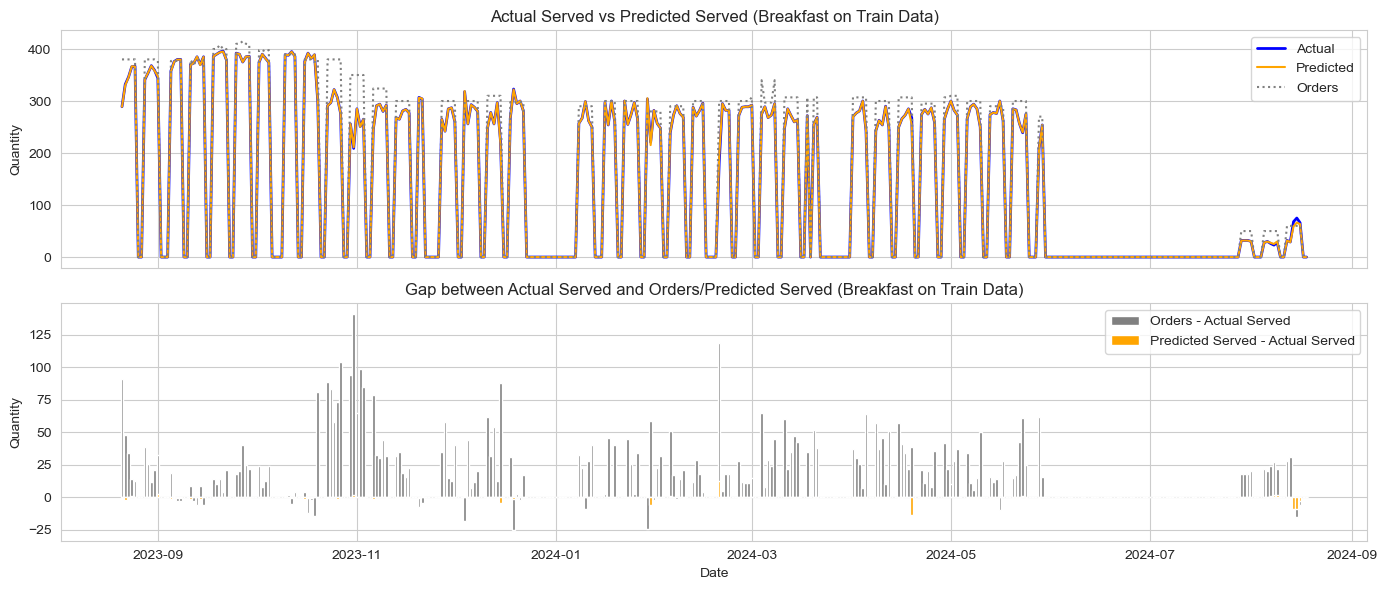

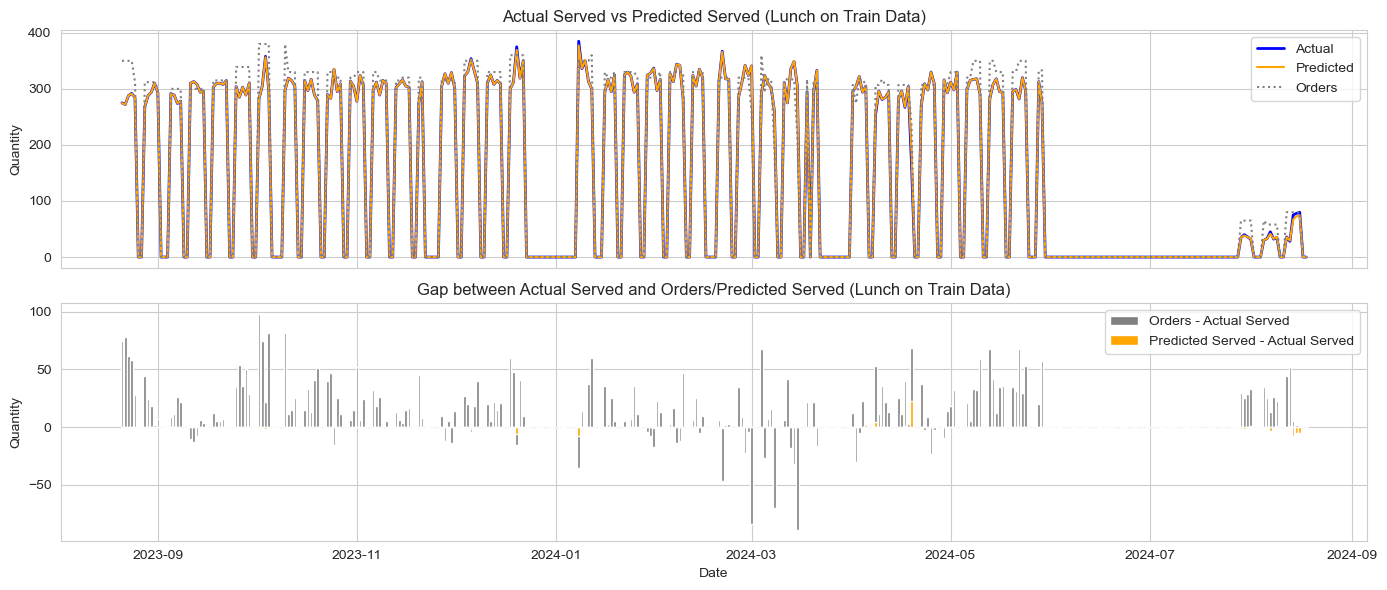

In [120]:
# breakfast
plot_data(y_train_breakfast, pred_train_breakfast, order_train_breakfast, 
          key='Breakfast on Train Data',
          trans=False)
# lunch
plot_data(y_train_lunch, pred_train_lunch, order_train_lunch, 
          key='Lunch on Train Data',
          trans=False)
# 可以看出橙色线（预测的served）和蓝色线（实际真实的served）几乎完全重叠，说明模型在训练集上可以实现准确的预测。相比于灰色线（order），极大的减少了每日order与served的差距。
# 当然，毕竟模型是在训练集上学习的，因此在训练集上预测效果好也是必然的，要是在训练集上效果都不好，那就更别提在未知的测试集上了。因此模型在训练集上的效果只是一种参考，并不能作为评价模型效果的最终标准，最终标准还得看在测试集上的效果如何。

#### 测试集上的效果

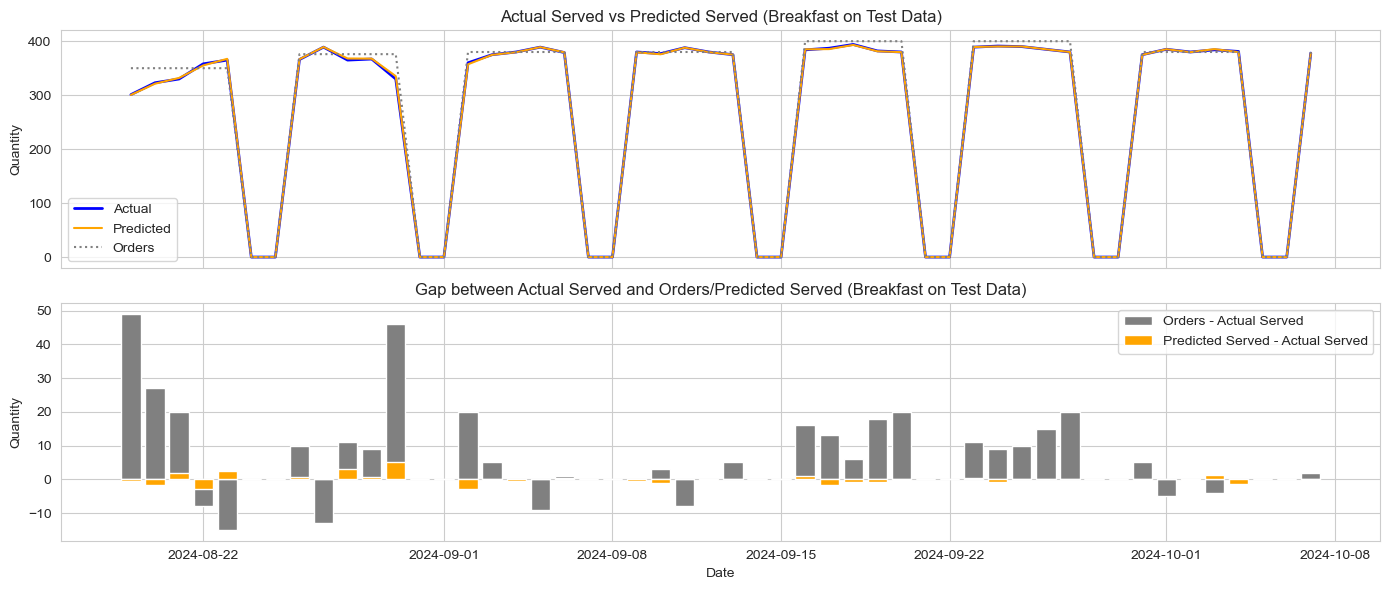

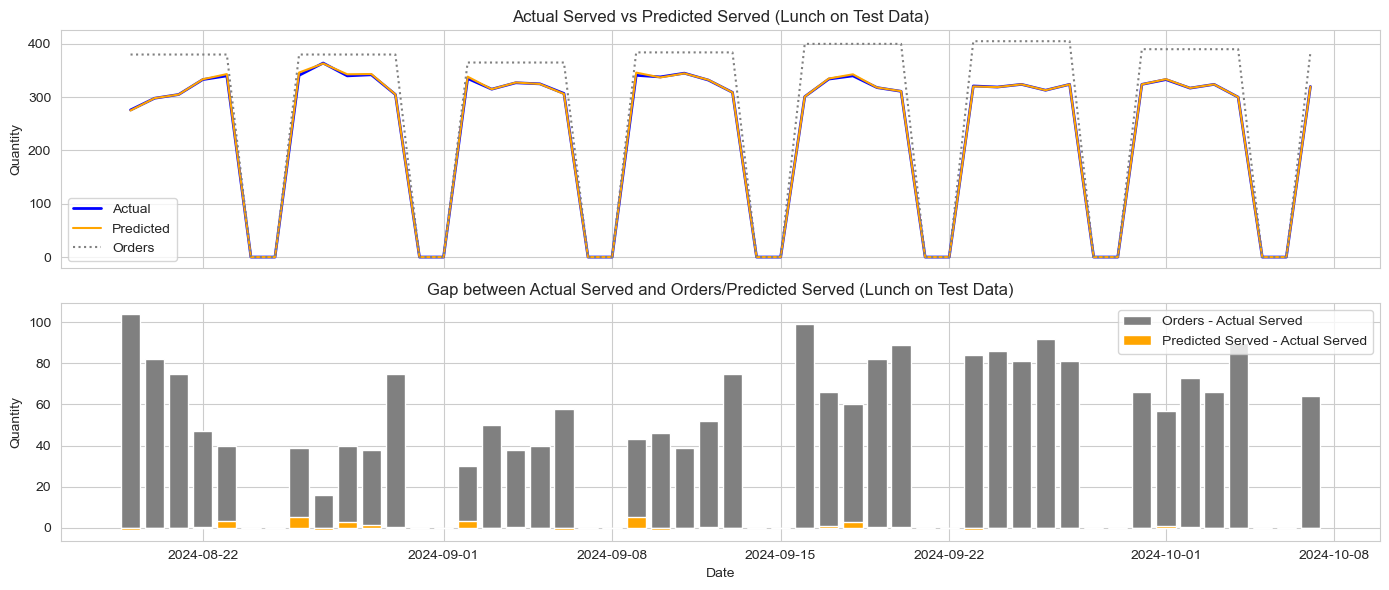

In [121]:
# breakfast
plot_data(y_test_breakfast, pred_test_breakfast, order_test_breakfast, 
          key='Breakfast on Test Data',
          trans=False)
# lunch
plot_data(y_test_lunch, pred_test_lunch, order_test_lunch, 
          key='Lunch on Test Data',
          trans=False)

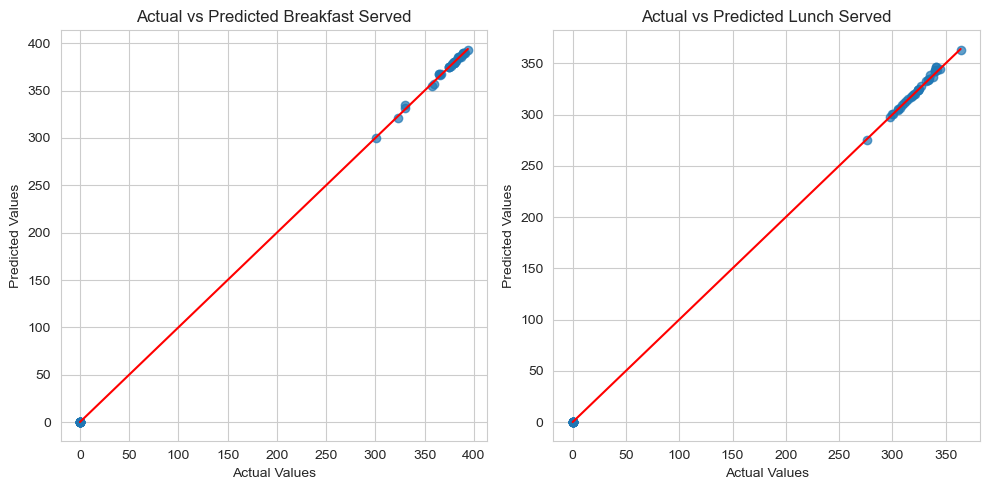

In [122]:
plt.figure(figsize=(10, 5))

# 散点图
plt.subplot(1, 2, 1)
plt.scatter(y_test_breakfast, pred_test_breakfast, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Breakfast Served')
plt.plot([y_test_breakfast.min(), y_test_breakfast.max()],
         [y_test_breakfast.min(), y_test_breakfast.max()], color='red')  # 理想预测线

plt.subplot(1, 2, 2)
plt.scatter(y_test_lunch, pred_test_lunch, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Lunch Served')
plt.plot([y_test_lunch.min(), y_test_lunch.max()],
         [y_test_lunch.min(), y_test_lunch.max()], color='red')  # 理想预测线

plt.tight_layout()
plt.show()

In [123]:
# 使用一些量化的指标来定量评估模型效果：在验证集上
breakfast_mse = mean_squared_error(y_test_breakfast, pred_test_breakfast)
lunch_mse = mean_squared_error(y_test_lunch, pred_test_lunch)
breakfast_mae = mean_absolute_error(y_test_breakfast, pred_test_breakfast)
lunch_mae = mean_absolute_error(y_test_lunch, pred_test_lunch)
breakfast_r2 = r2_score(y_test_breakfast, pred_test_breakfast)
lunch_r2 = r2_score(y_test_lunch, pred_test_lunch)

print(f'Breakfast MSE: {breakfast_mse}')
print(f'Lunch MSE: {lunch_mse}')
print(f'Breakfast MAE: {breakfast_mae}')
print(f'Lunch MAE: {lunch_mae}')
print(f'Breakfast R² Score: {breakfast_r2}')
print(f'Lunch R² Score: {lunch_r2}')

Breakfast MSE: 1.5423211669921875
Lunch MSE: 2.0311813354492188
Breakfast MAE: 0.68734375
Lunch MAE: 0.690859375
Breakfast R² Score: 0.9999455570515936
Lunch R² Score: 0.9999045645830233
